In [1]:
%matplotlib inline
import obspy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def stft(data, fs, fft_size=1024, overlap_fac=.1):
    # from https://kevinsprojects.wordpress.com/2014/12/13/short-time-fourier-transform-using-python-and-numpy/
    # data = a numpy array containing the signal to be processed
    # fs = a scalar which is the sampling frequency of the data

    hop_size = np.int32(np.floor(fft_size * (1-overlap_fac)))
    pad_end_size = fft_size          # the last segment can overlap the data by no more than one window size
    total_segments = np.int32(np.ceil(len(data) / np.float32(hop_size)))
    t_max = len(data) / np.float32(fs)

    window = np.hanning(fft_size)  # our half cosine window
    inner_pad = np.zeros(fft_size) # the zeros which will be used to double each segment size

    proc = np.concatenate((data, np.zeros(pad_end_size)))              # the data to process
    result = np.empty((total_segments, fft_size), dtype=np.float32)    # space to hold the result

    for i in xrange(total_segments):                      # for each segment
        current_hop = hop_size * i                        # figure out the current segment offset
        segment = proc[current_hop:current_hop+fft_size]  # get the current segment
        windowed = segment * window                       # multiply by the half cosine function
        padded = np.append(windowed, inner_pad)           # add 0s to double the length of the data
        spectrum = np.fft.fft(padded) / fft_size          # take the Fourier Transform and scale # samples
        autopower = np.abs(spectrum * np.conj(spectrum))  # find the autopower spectrum
        result[i, :] = autopower[:fft_size]               # append to the results array

    result = 20*np.log10(result)          # scale to db
    result = np.clip(result, -40, 200)    # clip values
    return result

Grab the data

In [3]:
url = 'http://opendap-devel.ooi.rutgers.edu:8080/opendap/hyrax/large_format/' + \
      'CE02SHBP-LJ01D-11-HYDBBA106/2016/01/10/OO-HYEA2--YDH-2016-01-10T04%3A25%3A00.000000.mseed'
stream = obspy.read(url)

Create a spectrogram

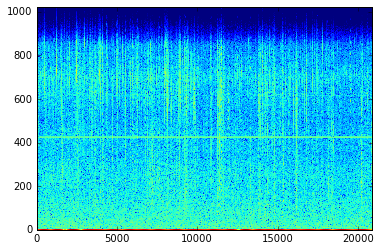

In [4]:
X = stft(stream[0].data, 64000)
plt.imshow(X.T, origin='lower', cmap='jet', interpolation='nearest', aspect='auto')

Filter out the DC component of the signal

In [5]:
filtered = stream.copy()
filtered.filter('highpass', freq=2.0)

1 Trace(s) in Stream:
OO.HYEA2..YDH | 2016-01-10T04:25:00.000000Z - 2016-01-10T04:29:59.998000Z | 64000.0 Hz, 19199873 samples

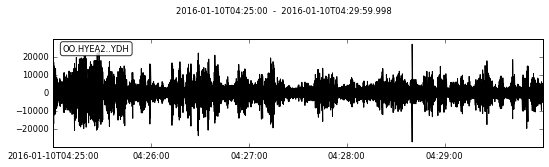

In [6]:
filtered.plot()

Write as WAV

In [7]:
filtered.write('voices.wav', format='WAV', framerate=64000, width=2)